In [2]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer

In [3]:
# Ensure GPU is available if needed
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
# Local dataset path (update this path based on your local setup)
dataset_path = '/Users/hannasav/downloads/qars/al5083'
train_image_dir = os.path.join(dataset_path, 'train')
test_image_dir = os.path.join(dataset_path, 'test')

In [8]:
# Parameters for quicker testing
NUM_TRAIN_IMAGES = 100  # Limit number of training images
NUM_TEST_IMAGES = 50    # Limit number of testing images
IMAGE_SIZE = (64, 64)   # Reduced image size for faster processing
BATCH_SIZE = 32         # Define batch size

In [10]:
# Function to load a limited number of image files from a directory
def get_limited_image_paths_and_labels(directory, label, limit=None):
    image_paths = []
    labels = []
    count = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
                labels.append(label)
                count += 1
                if limit and count >= limit:
                    return image_paths, labels
    return image_paths, labels

In [12]:
# Define a simplified image processing function
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMAGE_SIZE)  # Smaller size for faster processing
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

In [14]:
# Create TensorFlow Dataset with larger batch size if memory allows
def create_tf_dataset(image_paths, labels, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [16]:
# Get a limited number of images
train_image_paths, train_labels = get_limited_image_paths_and_labels(train_image_dir, label=1, limit=NUM_TRAIN_IMAGES)
test_image_paths, test_labels = get_limited_image_paths_and_labels(test_image_dir, label=0, limit=NUM_TEST_IMAGES)

In [18]:
def create_classical_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),  # Using InputLayer for the first layer
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Assuming binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
classical_model = create_classical_model()
history_classical = classical_model.fit(train_ds, epochs=1, validation_data=test_ds)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


NameError: name 'train_ds' is not defined

In [30]:
def create_quantum_model():
    dev = qml.device("default.qubit", wires=4)
    
    @qml.qnode(dev)
    def quantum_circuit(params, x):
        qml.AngleEmbedding(x, wires=range(4))
        qml.BasicEntanglerLayers(params, wires=range(4))
        return qml.expval(qml.PauliZ(0))
    
    def qnn(params, x):
        return quantum_circuit(params, x)
    
    class QuantumModel(tf.keras.Model):
        def __init__(self, n_qubits=4, n_layers=3):
            super(QuantumModel, self).__init__()
            self.params = tf.Variable(pnp.random.randn(n_layers, n_qubits, 3))
            self.optimizer = AdamOptimizer(0.1)
        
        def call(self, x):
            return tf.map_fn(lambda xi: qnn(self.params, xi), x, dtype=tf.float32)
        
        def train_step(self, data):
            x, y = data
            with tf.GradientTape() as tape:
                predictions = self(x)
                loss = tf.keras.losses.binary_crossentropy(y, predictions)
            gradients = tape.gradient(loss, [self.params])
            self.optimizer.apply_gradients(zip(gradients, [self.params]))
            return {'loss': loss}

    return QuantumModel()

In [32]:
quantum_model = create_quantum_model()
history_quantum = quantum_model.fit(train_ds, epochs=3, validation_data=test_ds)

NameError: name 'train_ds' is not defined

In [34]:
test_loss_classical, test_acc_classical = classical_model.evaluate(test_ds)
print(f'Classical model test accuracy: {test_acc_classical}')

test_loss_quantum, test_acc_quantum = quantum_model.evaluate(test_ds)
print(f'Quantum model test accuracy: {test_acc_quantum}')

NameError: name 'test_ds' is not defined

NameError: name 'history_classical' is not defined

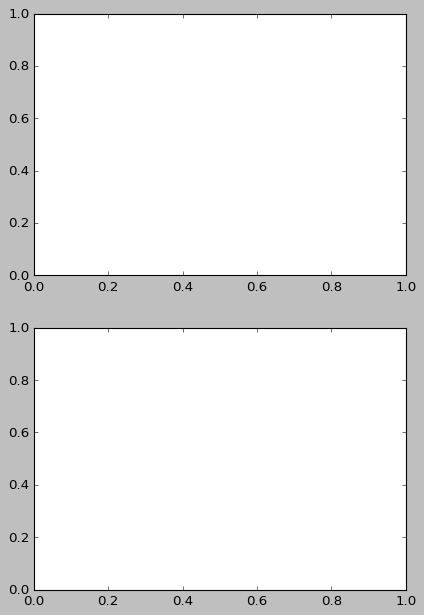

In [36]:
plt.style.use("classic")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))
ax1.plot(history_classical.history['val_accuracy'], "-og", label="Classical model")
ax1.plot(history_quantum.history['val_accuracy'], "-ob", label="Quantum model")
ax1.set_ylabel("Validation Accuracy")
ax1.legend()

ax2.plot(history_classical.history['val_loss'], "-og", label="Classical model")
ax2.plot(history_quantum.history['val_loss'], "-ob", label="Quantum model")
ax2.set_ylabel("Validation Loss")
ax2.legend()

plt.tight_layout()
plt.show()